<a href="https://colab.research.google.com/github/NikolValerie/homework/blob/main/08_03_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Фаза 2 • Неделя 8 • Среда
## Нейронные сети
### 🔥 PyTorch • CIFAR10

In [60]:
!pip install torchutils

In [110]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.datasets import CIFAR10
from torchvision import transforms as T
import torch.nn.functional as F

import numpy as np
import torchutils as tu
import matplotlib.pyplot as plt

Воспользуемся известным датасетом [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html), он содержит в себе изображения, принадлежащие 10 разным классам.

![](https://3065708918-files.gitbook.io/~/files/v0/b/gitbook-legacy-files/o/assets%2F-LRrOFNeUGLZef_2NLZ0%2F-LeEJi2MCK6d2wToNmIy%2F-LeENgJqZAzBJi8PRELl%2Fcifar10.png?alt=media&token=bee1e40d-b4f6-4f46-a835-43d3f1223166)

Датасет уже есть в torchvision.datasets, потому загрузим его сразу в нужном формате.

In [111]:
train_dataset = CIFAR10(
    root='data/',
    download=True,
    train=True,
    transform=T.Compose(
        [
            T.Resize((32, 32)), # на всякий случай применяем приведение к нужному размеру (тут он по умолчанию 32)
            T.ToTensor(),
            T.Normalize(
                (.5, .5, .5), (.5, .5, .5) # нормализация
            )
        ]
    )
)

valid_dataset = CIFAR10(
    root='data/',
    download=True,
    train=False,
    transform=T.Compose(
            [
                T.Resize((32, 32)),
                T.ToTensor(),
                T.Normalize(
                    (.5, .5, .5), (.5, .5, .5)
                )
            ]
        )
)

Files already downloaded and verified
Files already downloaded and verified


1. Создай два загрузчика (DataLoader): для обучающей и валидационной частей выборки.

In [112]:
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [113]:
def plot_history(history, grid=True):
    fig, ax = plt.subplots(1,2, figsize=(14,5))

    ax[0].plot(history['train_losses'], label='train loss')
    ax[0].plot(history['valid_losses'], label='valid loss')
    ax[0].set_title(f'Loss on epoch {len(history["train_losses"])}')
    ax[0].grid(grid)
    ax[0].legend()

    ax[1].plot(history['train_accs'], label='train acc')
    ax[1].plot(history['valid_accs'], label='valid acc')
    ax[1].set_title(f'Accuracy on epoch {len(history["train_losses"])}')
    ax[1].grid(grid)
    ax[1].legend()

    plt.show()

2. Задай класс модели в соответствии со схемой, приведенной ниже.

In [65]:
class BaseCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, # (w - k +2*p) / s + 1
                out_channels=4,
                kernel_size=5,
                stride=1,
                padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 8, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(8, 10, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc1 = nn.Linear(160, 120)
        # self.fc1 = nn.LazyLinear(16)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.drop_out = nn.Dropout()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.drop_out(out)
        out = self.fc2(out)
        return out


model = BaseCNN()

In [114]:
# cuda, если есть видеокарта,
# cpu – если делаем локально и без видеокарты,
# mps - если процессор M1/M2
DEVICE="cpu"

3. Вызови функцию `get_model_summary` из бибилиотеки `torchutils`.

In [67]:
tu.get_model_summary(model.to(DEVICE), torch.randn(BATCH_SIZE, 3, 32, 32, device=DEVICE))

Layer                     Kernel            Output        Params        FLOPs
0_layer1.Conv2d_0       [3, 4, 5, 5]   [128, 4, 32, 32]      304   39,845,888
1_layer1.ReLU_1                    -   [128, 4, 32, 32]        0            0
2_layer1.MaxPool2d_2               -   [128, 4, 16, 16]        0            0
3_layer2.Conv2d_0       [4, 8, 5, 5]   [128, 8, 16, 16]      808   26,476,544
4_layer2.ReLU_1                    -   [128, 8, 16, 16]        0            0
5_layer2.MaxPool2d_2               -     [128, 8, 8, 8]        0            0
6_layer3.Conv2d_0      [8, 10, 5, 5]    [128, 10, 8, 8]    2,010   16,465,920
7_layer3.ReLU_1                    -    [128, 10, 8, 8]        0            0
8_layer3.MaxPool2d_2               -    [128, 10, 4, 4]        0            0
9_fc1                     [160, 120]         [128, 120]   19,320    4,899,840
10_drop_out                        -         [128, 120]        0            0
11_fc2                     [120, 84]          [128, 84]   10,164

In [115]:
model = BaseCNN()
model.to(DEVICE) # переносим на используемое устройство

BaseCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=160, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (drop_out): Dropout(p=0.5, inplace=False)
)

4. Задай функцию потерь и оптимизатор.

In [69]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

5. Определи функцию `fit`, она должна возвращать данные, указанные в `docstring`. В функции должны присутствовать обучающие и валидационные шаги.

In [70]:
#def fit(model: torch.nn.Module, n_epochs: int = 30):

    #for epoch in range(n_epochs):
        #pass

        #for images, labels in train_loader:
            #pass

        #for images, labels in valid_loader:
            #pass

    #pass

    #return train_losses, valid_losses, train_acc, valid_acc

------------- Epoch 1 -------------
train: accuracy 0.5697, loss 1.2131
valid: accuracy 0.5904, loss 1.1519
-----------------------------------

------------- Epoch 2 -------------
train: accuracy 0.5726, loss 1.1999
valid: accuracy 0.5978, loss 1.1444
-----------------------------------

------------- Epoch 3 -------------
train: accuracy 0.5769, loss 1.1894
valid: accuracy 0.5974, loss 1.1277
-----------------------------------

------------- Epoch 4 -------------
train: accuracy 0.5811, loss 1.1784
valid: accuracy 0.5965, loss 1.1243
-----------------------------------

------------- Epoch 5 -------------
train: accuracy 0.5864, loss 1.1655
valid: accuracy 0.6057, loss 1.1071
-----------------------------------

------------- Epoch 6 -------------
train: accuracy 0.5898, loss 1.1566
valid: accuracy 0.6063, loss 1.1100
-----------------------------------

------------- Epoch 7 -------------
train: accuracy 0.5921, loss 1.1460
valid: accuracy 0.6057, loss 1.1032
----------------------

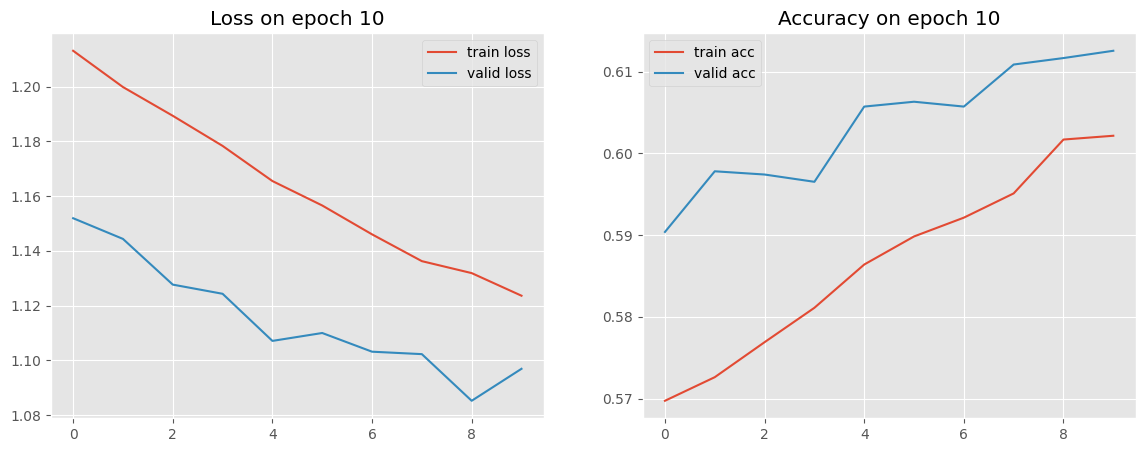

In [98]:
# Определяем цикл обучения
def fit_model(
        model: nn.Module,
        epochs: int,
        optimizer: torch.optim.Optimizer,
        history = None
        ) -> dict:
    '''
    model: pytorch model - model to train
    epochs: int          - number of epochs
    '''

    # будем сохранять значения точности и лосса в history
    history = history or {
        'train_accs': [],
        'train_losses': [],
        'valid_accs': [],
        'valid_losses': [],
    }

    # определяем текущую эпоху обучения
    start_epoch = len(history['train_accs'])
    for epoch in range(start_epoch+1, start_epoch+epochs+1):
        print(f'{"-"*13} Epoch {epoch} {"-"*13}')

        model.train()
        batch_accs = []
        batch_losses = []
        for samples, labels in train_loader:

            samples = samples.to(DEVICE)
            labels = labels.to(DEVICE)

            y_pred = model(samples)

            # Считаем лосс: передаем в функцию потерь предсказания и
            # настоящие метки классов
            # иногда надо переводить между long() и float(),
            # об этом pytorch предупредит

            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            # print(f'Predictions: {y_pred}')
            # сравниваем предсказания с таргетом и добавляем в
            # список значение точности
            # BATCH_SIZE x N_CLASSES = 64 X 10 -> argmax -> 64 x 1

            batch_accs.append((y_pred.argmax(axis=1) == labels).cpu().numpy().mean())

        history['train_losses'].append(np.mean(batch_losses))
        history['train_accs'].append(np.mean(batch_accs))

        # Validation
        model.eval()

        batch_accs = []
        batch_losses = []
        for samples, labels in valid_loader:
            with torch.no_grad():
                y_pred = model(samples.to(DEVICE))
            loss = criterion(y_pred, labels.to(DEVICE))
            batch_losses.append(loss.item())
            batch_accs.append((y_pred.cpu().argmax(axis=1) == labels.cpu()).numpy().mean())
        history['valid_accs'].append(np.mean(batch_accs))
        history['valid_losses'].append(np.mean(batch_losses))


        # печатаем результат

        print(
            f'train: accuracy {history["train_accs"][-1]:.4f}, loss {history["train_losses"][-1]:.4f}\n'
            f'valid: accuracy {history["valid_accs"][-1]:.4f}, loss {history["valid_losses"][-1]:.4f}'
        )
        print(f'{"-"*35}')
        print()

    # печатаем графики
    plot_history(history)

    return history

logs = fit_model(model, 10, optimizer)

6. Распечатай графики значений функции потерь на обучении и валидации, а также значения метрики на обучении и валидации.

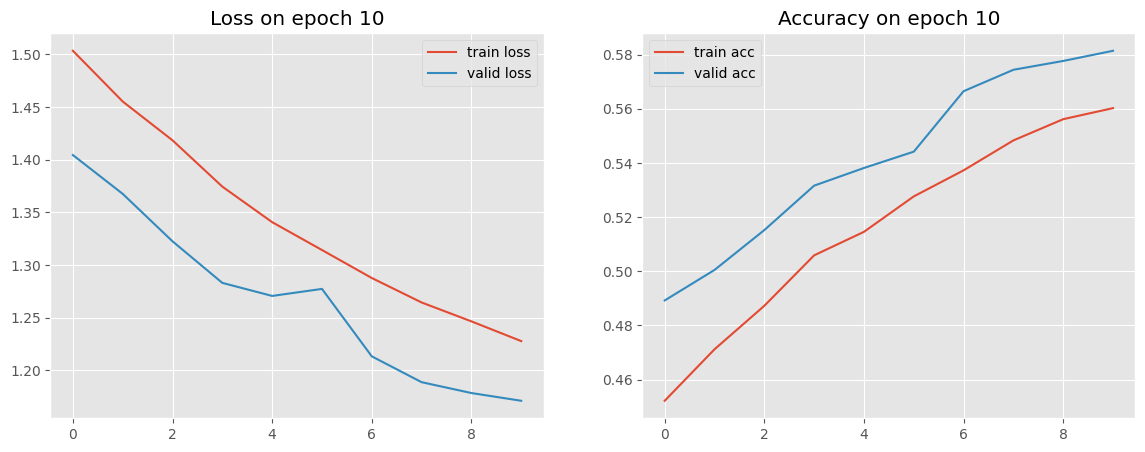

In [82]:
plt.style.use('ggplot')
plot_history(logs)
# code

7. Запиши результаты в переменные/словарь для последующего сравнения их с результатами более сложных моделей.

In [85]:
results = {"BaseCNN": logs}

8. Реализуй модель, изображенную на схеме ниже.

In [101]:
class ModifiedCNN(nn.Module):
  def __init__(self):
      super(ModifiedCNN, self).__init__()
      self.layer1 = nn.Sequential(
          nn.Conv2d(3, 16, 3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2, 2) )


      self.layer2 = nn.Sequential(
          nn.Conv2d(16, 32, 3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2, 2))

      self.layer3 = nn.Sequential(
          nn.Conv2d(32, 64, 3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2, 2))

      self.fc1 = nn.Linear(64*4*4, 512)
      self.fc2 = nn.Linear(512, 64)
      self.fc3 = nn.Linear(64, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)
      out = out.view(out.size(0), -1)
      out = self.fc1(out)
      out = F.relu(out)
      out = self.fc2(out)
      out = F.relu(out)
      out = self.fc3(out)
      out = F.relu(out)
      return out


Layer                      Kernel            Output         Params          FLOPs
0_layer1.Conv2d_0       [3, 16, 3, 3]   [128, 16, 32, 32]       448    58,720,256
1_layer1.ReLU_1                     -   [128, 16, 32, 32]         0             0
2_layer1.MaxPool2d_2                -   [128, 16, 16, 16]         0             0
3_layer2.Conv2d_0      [16, 32, 3, 3]   [128, 32, 16, 16]     4,640   152,043,520
4_layer2.ReLU_1                     -   [128, 32, 16, 16]         0             0
5_layer2.MaxPool2d_2                -     [128, 32, 8, 8]         0             0
6_layer3.Conv2d_0      [32, 64, 3, 3]     [128, 64, 8, 8]    18,496   151,519,232
7_layer3.ReLU_1                     -     [128, 64, 8, 8]         0             0
8_layer3.MaxPool2d_2                -     [128, 64, 4, 4]         0             0
9_fc1                     [1024, 512]          [128, 512]   524,800   134,152,192
10_fc2                      [512, 64]           [128, 64]    32,832     8,380,416
11_fc3          

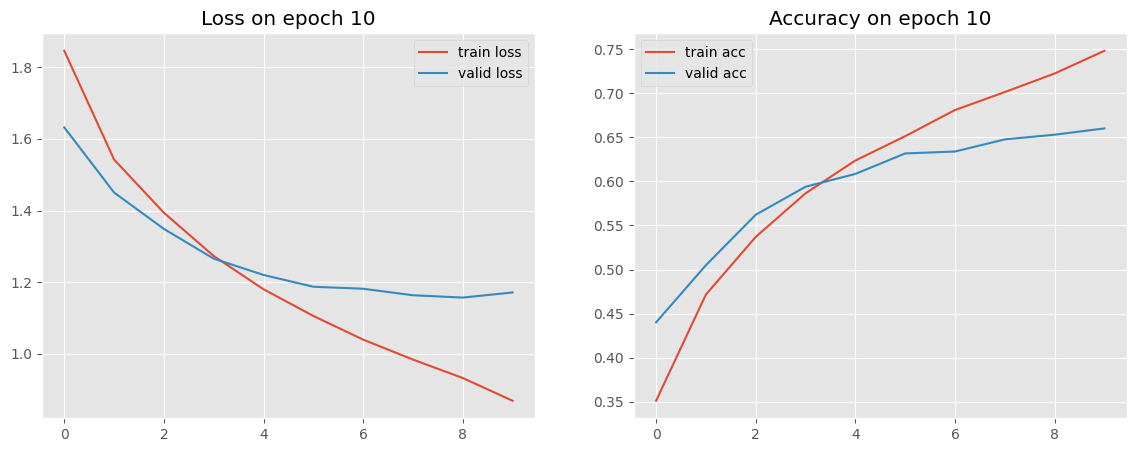

In [103]:
model_modified = ModifiedCNN()
tu.get_model_summary(model_modified, torch.randn(BATCH_SIZE, 3, 32, 32, device=DEVICE))
model_modified.to(DEVICE)

optimizer = torch.optim.Adam(model_modified.parameters())
criterion = torch.nn.CrossEntropyLoss()

logs = fit_model(model_modified, 10, optimizer)

9. Обучи модифицированную модель с помощью функции `fit()` и повтори шаги 6 и 7 для текущей модели. Не забудь передать в оптимизатор новые параметры (= создай его заново).

In [75]:
# code

10. Реализуй архитектуру, приведенную ниже на схеме. Повтори для нее шаги 6 и 7.

11. Выясни по метриками, какая модель оказалась самой эффективной и сохрани в отдельный файл `best_model.py` ее класс, а в файл `best_model.pt` ее [веса](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference).

In [108]:
class BigCNN(nn.Module):
  def __init__(self):
      super(BigCNN, self).__init__()
      self.layer1 = nn.Sequential(
          nn.Conv2d(3, 32, 3, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(32, 64, 3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2, 2))

      self.layer2 = nn.Sequential(
          nn.Conv2d(64, 128, 3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(128, 128, 3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2, 2))

      self.layer3 = nn.Sequential(
          nn.Conv2d(128, 256, 3, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(256, 256, 3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2, 2))

      self.fc1 = nn.Linear(256*4*4, 512)
      self.fc2 = nn.Linear(512, 64)
      self.fc3 = nn.Linear(64, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    out = F.relu(out)
    out = self.fc3(out)
    return out

In [2]:
model_modified2 = BigCNN()
tu.get_model_summary(model_modified2, torch.randn(BATCH_SIZE, 3, 32, 32, device=DEVICE))
model_modified2.to(DEVICE)

optimizer = torch.optim.Adam(model_modified2.parameters())
criterion = torch.nn.CrossEntropyLoss()

logs = fit_model(model_modified2, 10, optimizer)

NameError: name 'BigCNN' is not defined

12. Используй модель, показавшую наибольшее качество. Обучи ее дважды на двух наборах данных:
* Датасет без аугментаций (тот, который был создан выше)
* Датасет с аугментациями (их надо добавить в Compose в аргумент датасета transform)):
  * [ColorJitter](https://pytorch.org/vision/stable/generated/torchvision.transforms.ColorJitter.html#torchvision.transforms.ColorJitter)
  * [RandomRotation](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomRotation.html#torchvision.transforms.RandomRotation)
  * [RandomHorizontalFlip](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip)
Для этого создай два новых датасета (обучение/валидация) с названиями `trani_aug_dataset` и `valid_aug_dataset` и два загрузчика `train_aug_loader` и `valid_aug_loader`.


Обучение должно происходить в течение 20 эпох (оптимизатор и его параметры на твое усмотрение).

❓ Какой из двух вариантов показывает лучшее качество на валидационной части данных: где данными выступали обычные изображения без аугментаций или аугментированные данные?

#### LeNet model

1. Реализуй модель LeNet в соответствии со схемой ниже, обучи её и сравни результаты с лучше собственной моделью (из реализованных выше). Число каналов во первом слое модели нужно изменить на 3, т.к. картинки цветные.  

<img src="https://www.philschmid.de/static/blog/getting-started-with-cnn-by-calculating-lenet-layer-manually/lenet-5.svg">

In [78]:
class LeNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        ...

    def forward(self, x: torch.Tensor):
        pass

In [79]:
# code

2. Обучи новый экземпляр модели LeNet, но на этот раз добавь в функцию потерь аргумент `label_smoothing=.2`. Сравни результат с предыдущим этапом.

In [80]:
# code